## pendulum-v0という連続値行動をDDPGで学習

In [1]:
import numpy as np
import copy
from collections import deque
import gym
# from gym import wrappers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.distributions import Categorical, Normal
# import matplotlib
# import matplotlib.animation as animation
import matplotlib.pyplot as plt

In [2]:
# actorのネットワーク（状態を入力にして行動（スカラー値)を出力）
class ActorNetwork(nn.Module):
    def __init__(self, num_state, action_space, hidden_size=16):
        super(ActorNetwork, self).__init__()
        self.action_mean = torch.tensor(0.5*(action_space.high+action_space.low),
                                        dtype=torch.float)  # 0.0
        self.action_halfwidth = torch.tensor(0.5*(action_space.high-action_space.low),
                                             dtype=torch.float)  # 4.0
        # 3(状態)-->16-->16-->1(どのぐらい回すかの行動)
        self.fc1 = nn.Linear(num_state, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_space.shape[0])

    def forward(self, s):
        h = F.elu(self.fc1(s))
        h = F.elu(self.fc2(h))
        a = self.action_mean + self.action_halfwidth*torch.tanh(self.fc3(h))
        return a


In [3]:
# criticのネットワーク（状態と行動を入力にしてQ値を出力）
class CriticNetwork(nn.Module):
    def __init__(self, num_state, action_space, hidden_size=16):
        super(CriticNetwork, self).__init__()
        self.action_mean = torch.tensor(0.5*(action_space.high+action_space.low),
                                        dtype=torch.float)
        self.action_halfwidth = torch.tensor(0.5*(action_space.high-action_space.low),
                                             dtype=torch.float)
        # 3(状態)+1(行動)-->16-->16-->1(Q値)
        self.fc1 = nn.Linear(num_state+action_space.shape[0], hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_space.shape[0])

    def forward(self, s, a):
        a = (a-self.action_mean)/self.action_halfwidth  # [-1,1]の範囲に正規化
        h = F.elu(self.fc1(torch.cat([s, a], 1)))
        h = F.elu(self.fc2(h))
        q = self.fc3(h)
        return q

In [4]:
class ReplayBuffer:  # リプレイバッファの定義
    def __init__(self, memory_size):
        self.memory_size = memory_size
        self.memory = deque([], maxlen=memory_size)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        batch_indexes = np.random.randint(0, len(self.memory), size=batch_size)
        states = np.array([self.memory[index]['state']
                          for index in batch_indexes])
        next_states = np.array([self.memory[index]['next_state']
                               for index in batch_indexes])
        rewards = np.array([self.memory[index]['reward']
                           for index in batch_indexes])
        actions = np.array([self.memory[index]['action']
                           for index in batch_indexes])
        dones = np.array([self.memory[index]['done']
                         for index in batch_indexes])
        return {'states': states, 'next_states': next_states, 'rewards': rewards, 'actions': actions, 'dones': dones}


In [5]:
class DdpgAgent:
    def __init__(self, observation_space, action_space, gamma=0.99, lr=1e-3, batch_size=32, memory_size=50000):
        self.num_state = observation_space.shape[0]
        self.num_action = action_space.shape[0]
        self.state_mean = 0.5*(observation_space.high + observation_space.low)
        self.state_halfwidth = 0.5 * (observation_space.high -
                                      observation_space.low)
        self.gamma = gamma  # 割引率
        self.batch_size = batch_size
        self.actor = ActorNetwork(self.num_state, action_space)
        self.actor_target = copy.deepcopy(self.actor)  # actorのターゲットネットワーク
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic = CriticNetwork(self.num_state, action_space)
        self.critic_target = copy.deepcopy(self.critic)  # criticのターゲットネットワーク
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer(memory_size)

    # 連続値の状態を[-1,1]の範囲に正規化
    def normalize_state(self, state):
        state = (state-self.state_mean)/self.state_halfwidth
        return state

    # リプレイバッファからサンプルされたミニバッチをtensorに変換
    def batch_to_tensor(self, batch):
        states = torch.tensor([self.normalize_state(s) for s in batch["states"]],
                              dtype=torch.float)
        actions = torch.tensor(batch["actions"], dtype=torch.float)
        next_states = torch.tensor([self.normalize_state(s) for s in batch["next_states"]],
                                   dtype=torch.float)
        rewards = torch.tensor(batch["rewards"], dtype=torch.float)
        return states, actions, next_states, rewards

    # actorとcriticを更新
    def update(self):
        batch = self.replay_buffer.sample(self.batch_size)
        states, actions, next_states, rewards = self.batch_to_tensor(batch)

        # criticの更新
        # target_qの勾配を更新しない(ヒント：　.data, ().detach)
        target_q = (rewards + self.gamma*self.critic_target(next_states,
                                                            self.actor_target(next_states)).squeeze()).data
        q = self.critic(states, actions).squeeze()
        critic_loss = F.mse_loss(q, target_q)  # q, target_qの差を最小化する
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # actorの更新
        # actorはQ関数 𝑄𝜙(𝑠,𝜋𝜃(𝑠)) の値が最大となるように学習
        actor_loss = -self.critic(states, self.actor(states)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ターゲットネットワークのパラメータを更新
        self.critic_target = copy.deepcopy(self.critic)
        self.actor_target = copy.deepcopy(self.actor)

    # Q値が最大の行動を選択
    def get_action(self, state):
        state_tensor = torch.tensor(self.normalize_state(state),
                                    dtype=torch.float).view(-1, self.num_state)
        action = self.actor(state_tensor).view(self.num_action)
        return action

In [6]:
# 各種設定
num_episode = 250  # 学習エピソード数（学習に時間がかかるので短めにしています）
memory_size = 50000  # replay bufferの大きさ
initial_memory_size = 1000  # 最初に貯めるランダムな遷移の数
# ログ用の設定
episode_rewards = []
num_average_epidodes = 10

env = gym.make('Pendulum-v0')
max_steps = env.spec.max_episode_steps  # エピソードの最大ステップ数
agent = DdpgAgent(env.observation_space, env.action_space,
                  memory_size=memory_size)

1000 Data collected


C:\Users\machapin\AppData\Local\Temp\ipykernel_14536\1313088457.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  states = torch.tensor([self.normalize_state(s) for s in batch["states"]],


Episode 0 finished | Episode reward -1091.782727
Episode 20 finished | Episode reward -1574.479412
Episode 40 finished | Episode reward -1492.674295
Episode 60 finished | Episode reward -1291.411107
Episode 80 finished | Episode reward -1375.054790
Episode 100 finished | Episode reward -1411.042530
Episode 120 finished | Episode reward -1454.527899
Episode 140 finished | Episode reward -1479.857494
Episode 160 finished | Episode reward -1542.463954
Episode 180 finished | Episode reward -1524.854819
Episode 200 finished | Episode reward -1515.011947
Episode 220 finished | Episode reward -1530.191253
Episode 240 finished | Episode reward -1495.742561


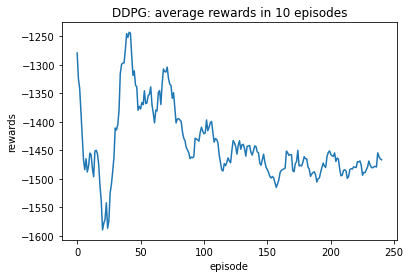

In [7]:
# 最初にreplay bufferにランダムな行動をしたときのデータを入れる
state = env.reset()
for step in range(initial_memory_size):
    action = env.action_space.sample()  # ランダムに行動を選択
    next_state, reward, done, _ = env.step(action)
    transition = {
        'state': state,
        'next_state': next_state,
        'reward': reward,
        'action': action,
        'done': int(done)
    }
    agent.replay_buffer.append(transition)
    state = env.reset() if done else next_state
print('%d Data collected' % (initial_memory_size))

for episode in range(num_episode):
    state = env.reset()  # envからは3次元の連続値の観測が返ってくる
    episode_reward = 0
    for t in range(max_steps):
        action = agent.get_action(state).data.numpy()  # 行動を選択
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        transition = {
            'state': state,
            'next_state': next_state,
            'reward': reward,
            'action': action,
            'done': int(done)
        }
        agent.replay_buffer.append(transition)
        agent.update()  # actorとcriticを更新
        state = next_state
        if done:
            break
    episode_rewards.append(episode_reward)
    if episode % 20 == 0:
        print("Episode %d finished | Episode reward %f" %
              (episode, episode_reward))

# 累積報酬の移動平均を表示
moving_average = np.convolve(episode_rewards, np.ones(
    num_average_epidodes)/num_average_epidodes, mode='valid')
plt.plot(np.arange(len(moving_average)), moving_average)
plt.title('DDPG: average rewards in %d episodes' % num_average_epidodes)
plt.xlabel('episode')
plt.ylabel('rewards')
plt.show()

env.close()
